# fMRI-04 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

This notebook provides an overview of reading, manipulating, and saving fMRI data in python.

## Part 1: The Python fMRI Ecosystem

Traditionally, fMRI researchers have relied on one of several software libraries for performing fMRI analysis. Packages such as [SPM](https://www.fil.ion.ucl.ac.uk/spm/) (Matlab, UCL), [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/) (C/python, Oxford), [AFNI](https://afni.nimh.nih.gov/) (C, NIMH), and [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) (C/Matlab, MGH) are still the major workhouses for fMRI analysis. As the field of fMRI analysis has advanced (and as the wider fMRI community has grown more computationally savvy), there's been an increasing push to centralize and standardize tools and incorporate fMRI analysis into larger analytic workflows.

Unsurprisingly then, there's been a collosal effort to move fMRI analysis into the python ecosystem (and also R). The most prominent example of this is [NIPY](https://nipy.org/), a constellation of python packages for (f)MRI preprocessing and analysis including:

- [nipype](https://nipype.readthedocs.io/en/latest/): a pythonic interface to existing neuroimaging software (and basis for fmriprep)
- [nibabel](https://nipy.org/nibabel/): provides read/write access to some common neuroimaging file formats
- [nitime](http://nipy.org/nitime/): time-series analysis of data from neuroscience experiments
- [nilearn](https://nilearn.github.io/): statistical learning on neuroimaging data
- [pymvpa](http://www.pymvpa.org/): machine learning for neuroimaging data
- [mindboggle](https://mindboggle.info/): automated labeling and shape analysis of human brain image data 
- [mne](http://martinos.org/mne/stable/index.html): software for m/eeg data analysis
- [pysurfer](https://pysurfer.github.io/): visualizing cortical surface representations of neuroimaging data

In the tutorials below, we will be covering only the basic functions available across these libraries. We encourage you to check some of them out though. To note, there are number of other great up-and-coming MRI packages in python to earmark as well:

- [brainiak](https://brainiak.org/): advanced fMRI analyses in Python
- [fitlins](https://github.com/poldracklab/fitlins): automated first-level analysis through fmriprep
- [lyman](https://github.com/mwaskom/lyman): python port of FSL
- [FIRdeconvolution](https://github.com/tknapen/FIRDeconvolution): deconvolution algorithms for timeseries data
- [neurodesign](https://github.com/neuropower/neurodesign): tools for fMRI experimental design and power analysis

## Part 2: Standard Space(s)

As if fMRI analysis was not convoluted enough already, we first need to have a conversation about standard spaces before moving onto analysis. Over the course of fMRI processing, the functional data is often spatially transformed into another "space"—typically a standard space. We'll need to keep the following distinctions in mind during analysis:

* native space vs. standard space
* volume space vs. surface space
* standard volume spaces and templates, e.g. MNI152, MNI305
* standard surface spaces and templates, e.g. fsaverage

The first distinction is between native and standard space. Native space refers to the subject-specific configuration under which the data were collected. Analyzing data in native space requires the minimal amount of data manipulation (e.g. aligning and resampling), but the lack of voxelwise correspondence across subjects prevents some types of group analysis. To achieve voxelwise correspondence across subjects, we typically perform spatial normalization to align each subject's data to a template image (e.g. *MNI152NLin2009cAsym*) in a standard space (e.g. *MNI space*). There are several standard spaces. Although "MNI space" is very widely used, there are in fact many specific *templates* in MNI space that each differ in small ways (read more [about the MNI space(s)](https://www.lead-dbs.org/about-the-mni-spaces/) at Lead-DBS).

The second distinction is between volume- and surface-based analysis. MRI data are collected in a volumetric format where each data point corresponds to a voxel at a particular location in a three-dimensional grid; volumetric analysis retains this three-dimensional grid representation of the data. In contrast, surface-based analysis is argued to better capture the sheet-like structure of the cortical mantle. In surace-based analysis, the functional data are resampled onto two-dimensional graph-like triangular mesh where each data point corresponds to a vertex at a particular location in the mesh. Importantly, two voxels on either side of a sulcus may appear to be close according to their Euclidean distance in volume space, whereas surface space more accurately that they are farther apart in terms of geodesic distance on the folded cortical surface. The *fsaverage* template is typically used for spatial normalization of surface-based data.

## Part 3: Working with Volume Data

### Reading / Writing Volume Data
Reading in MRI data is easy with `nibabel`. For a more complete tutorial, see [here](https://nipy.org/nibabel/gettingstarted.html).

In [2]:
import nibabel as nib

## Load anatomical data.
obj = nib.load('T1.nii.gz')

Nibabel objects store many useful pieces of information, including the data, the affine transformation, and the header.

In [3]:
## Show header.
print(obj.header.keys()[:10])

['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2']


Extracting data is similarly easy.

(76, 76, 93)


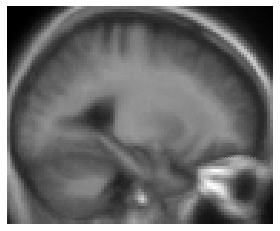

In [4]:
## Extract data.
data = obj.get_fdata()
print(data.shape)

## Visualize one slide.
sns.heatmap(data[50], cmap='binary_r', square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

Saving data is also easy. Whenever we save data, we must also store its associated affine transformation (otherwise we will not know how to interpret its spatial reference frame).

In [5]:
## Store data as Nifti image.
nifti = nib.Nifti1Image(data, obj.affine)

## Save data.
# nib.save(nifti, 'example.nii.gz')

### Masking Volume Data

Because MRI data are just NumPy arrays, masking data is simply an indexing problem. Below, we demonstrate masking with the brainmask and with an anatomical atlas.

#### Brainmask

(76, 76, 93)


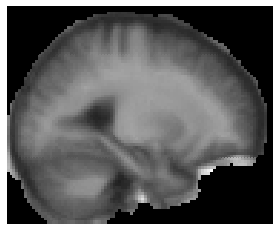

In [6]:
## Load brainmask.
mask = nib.load('brainmask.nii.gz').get_fdata()
print(mask.shape)

## Make copy of data.
copy = data.copy()

## Mask out nonbrain.
copy[mask == 0] = 0

## Visualize one slide.
sns.heatmap(copy[50], cmap='binary_r', square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

#### FreeSurfer "aseg"
The labels corresponding to each ROI were found using the Freesurfer [color lookup table](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT).

(76, 76, 93)


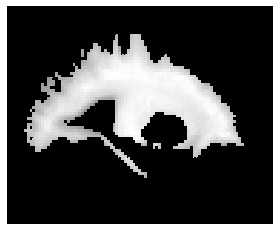

In [7]:
## Load brainmask.
aseg = nib.load('aseg.nii.gz').get_fdata()
print(aseg.shape)

## Make copy of data.
copy = data.copy()

## Mask out all but left hemisphere white matter.
copy[aseg != 2] = 0.

## Visualize one slide.
sns.heatmap(copy[50], cmap='binary_r',square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

## Part 4: Working with Surface (2d) Data

### Reading / Writing Surface Data
Reading in MRI data is easy with `nibabel`. For a more complete tutorial, see [here](https://nipy.org/nibabel/gettingstarted.html).

In [8]:
## Load surface data.
obj = nib.load('surface-lh.nii.gz')

## Extract data.
data = obj.get_fdata()
print(data.shape)

## Store data as Nifti image.
nifti = nib.Nifti1Image(data, obj.affine)

## Save data.
# nib.save(nifti, 'example.nii.gz')

(10242, 1, 1, 1)


## Masking Surface Data

Masks in surface space are known as labels. Labels are simply a collection of vertices associated with a particular region of interest. We will use `mne` to read in an exampe label.

In [9]:
from mne import read_label

## Load V1 label.
label = read_label('V1-lh.label')
print(label.vertices.size)

## Limit data to V1.
v1 = data[label.vertices]
print(v1.shape)

ModuleNotFoundError: No module named 'mne'